In [204]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro, skew, kurtosis
from sklearn.preprocessing import StandardScaler
from pyproj import CRS
import rasterio
from rasterio.transform import from_origin
from pykrige.ok import OrdinaryKriging
import ee


Caricamento e stampa dei primi dati del dataset

In [205]:
# Carica il dataset GPKG
gdf = gpd.read_file("resa_girasole_2022.gpkg")
print("dataframe: ", gdf.shape)

# Controlla le prime righe per assicurarti che i dati siano caricati correttamente
gdf.head()

dataframe:  (1962, 8)


,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,NaN,POINT (1333142.685 5597543.903)
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,NaN,POINT (1333141.706 5597572.841)
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,NaN,POINT (1333141.672 5597604.934)
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.1,POINT (1333142.284 5597633.165)
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.1,POINT (1333142.195 5597662.213)


Analisi dei dati

Controllo sulla presenza di parametri nulli 

In [206]:
# Verifica i valori mancanti
sumNull = gdf.isnull().sum()
print('valori nulli: ', sumNull)


valori nulli:  Data/Ora       0
Longitudin     0
Latitudine     0
RESAKG         0
VELOCITA       0
AREA           0
UMIDITA       37
geometry       0
dtype: int64


In [207]:
# Sostituzione dei valori mancanti con la media
gdf['UMIDITA'] = gdf['UMIDITA'].fillna(gdf['UMIDITA'].mean())

 # verifica di feature mancanti 
sumNull = gdf.isnull().sum()
print('valori nulli: ', sumNull)


valori nulli:  Data/Ora      0
Longitudin    0
Latitudine    0
RESAKG        0
VELOCITA      0
AREA          0
UMIDITA       0
geometry      0
dtype: int64


Controllo degli outlier

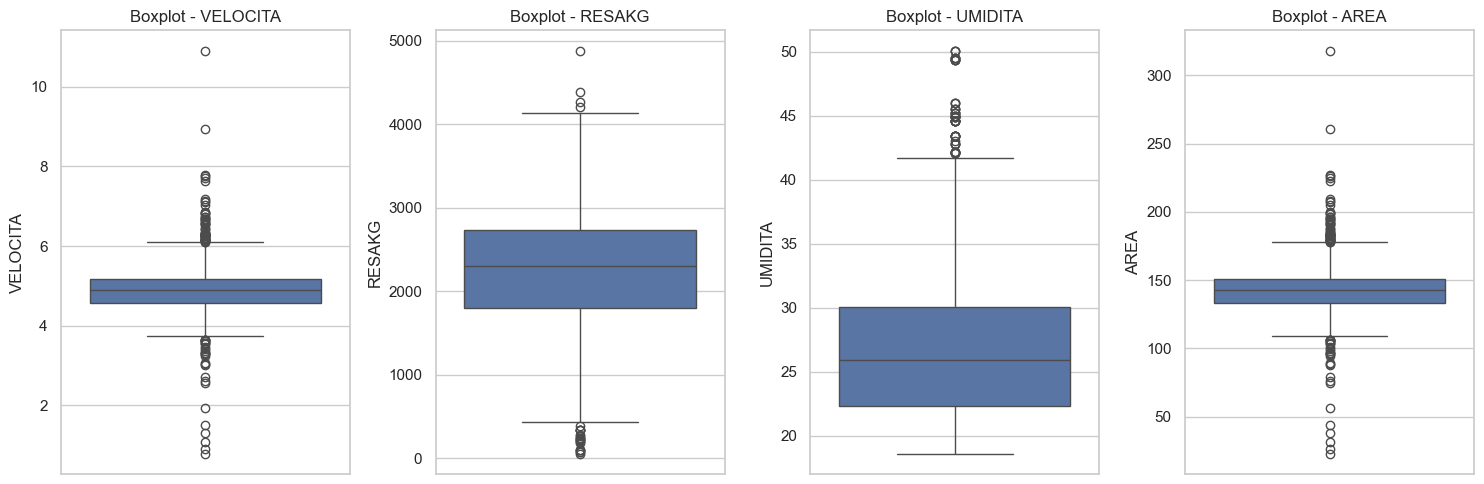

In [208]:
# Imposta il tema di Seaborn per migliori visualizzazioni
sns.set(style="whitegrid")

# Crea boxplot per ogni variabile
plt.figure(figsize=(15, 5))

# Boxplot per VELOCITA
plt.subplot(1, 4, 1)
sns.boxplot(y=gdf['VELOCITA'])
plt.title('Boxplot - VELOCITA')

# Boxplot per RESAKG
plt.subplot(1, 4, 2)
sns.boxplot(y=gdf['RESAKG'])
plt.title('Boxplot - RESAKG')

# Boxplot per UMIDITA
plt.subplot(1, 4, 3)
sns.boxplot(y=gdf['UMIDITA'])
plt.title('Boxplot - UMIDITA')

# Boxplot per AREA
plt.subplot(1, 4, 4)
sns.boxplot(y=gdf['AREA'])
plt.title('Boxplot - AREA')

plt.tight_layout()
plt.show()

In [221]:
# Calcolo dell'IQR per ogni variabile
Q1_vel, Q3_vel = gdf['VELOCITA'].quantile([0.25, 0.75])
IQR_vel = Q3_vel - Q1_vel

Q1_resa, Q3_resa = gdf['RESAKG'].quantile([0.25, 0.75])
IQR_resa = Q3_resa - Q1_resa

Q1_umid, Q3_umid = gdf['UMIDITA'].quantile([0.25, 0.75])
IQR_umid = Q3_umid - Q1_umid

Q1_area, Q3_area = gdf['AREA'].quantile([0.25, 0.75])
IQR_area = Q3_area - Q1_area

# Limiti per gli outlier
lower_bound_vel = Q1_vel - 1.5 * IQR_vel
upper_bound_vel = Q3_vel + 1.5 * IQR_vel

lower_bound_resa = Q1_resa - 1.5 * IQR_resa
upper_bound_resa = Q3_resa + 1.5 * IQR_resa

lower_bound_umid = Q1_umid - 1.5 * IQR_umid
upper_bound_umid = Q3_umid + 1.5 * IQR_umid

lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area

gdf = gdf[(gdf['VELOCITA'] >= lower_bound_vel) & (gdf['VELOCITA'] <= upper_bound_vel)]
gdf = gdf[(gdf['RESAKG'] >= lower_bound_resa) & (gdf['RESAKG'] <= upper_bound_resa)]
gdf = gdf[(gdf['UMIDITA'] >= lower_bound_umid) & (gdf['UMIDITA'] <= upper_bound_umid)]
gdf = gdf[(gdf['AREA'] >= lower_bound_umid) & (gdf['UMIDITA'] <= upper_bound_umid)]

print("dataframe: ", gdf.shape)
# Reindicizzazione per evitare "buchi" nell'indice
gdf = gdf.reset_index(drop=True)

dataframe:  (1757, 8)


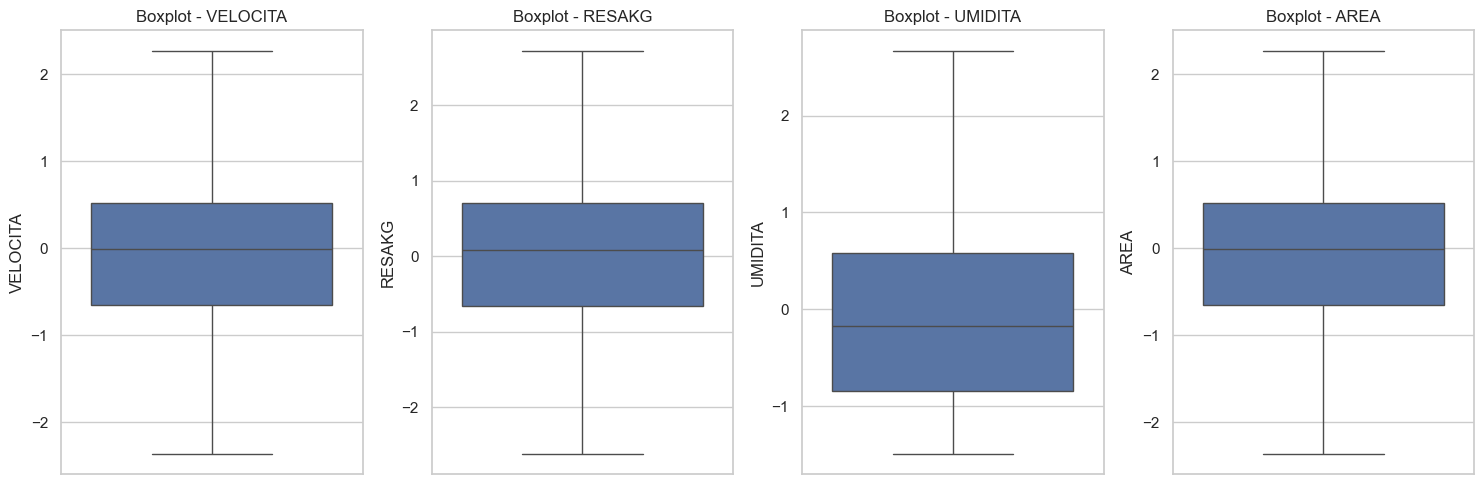

In [222]:
# Imposta il tema di Seaborn per migliori visualizzazioni
sns.set(style="whitegrid")

# Crea boxplot per ogni variabile
plt.figure(figsize=(15, 5))

# Boxplot per VELOCITA
plt.subplot(1, 4, 1)
sns.boxplot(y=gdf['VELOCITA'])
plt.title('Boxplot - VELOCITA')

# Boxplot per RESAKG
plt.subplot(1, 4, 2)
sns.boxplot(y=gdf['RESAKG'])
plt.title('Boxplot - RESAKG')

# Boxplot per UMIDITA
plt.subplot(1, 4, 3)
sns.boxplot(y=gdf['UMIDITA'])
plt.title('Boxplot - UMIDITA')

# Boxplot per AREA
plt.subplot(1, 4, 4)
sns.boxplot(y=gdf['AREA'])
plt.title('Boxplot - AREA')

plt.tight_layout()
plt.show()

Normalizzazione dei dati

controllo delle distribuzioni dei dati

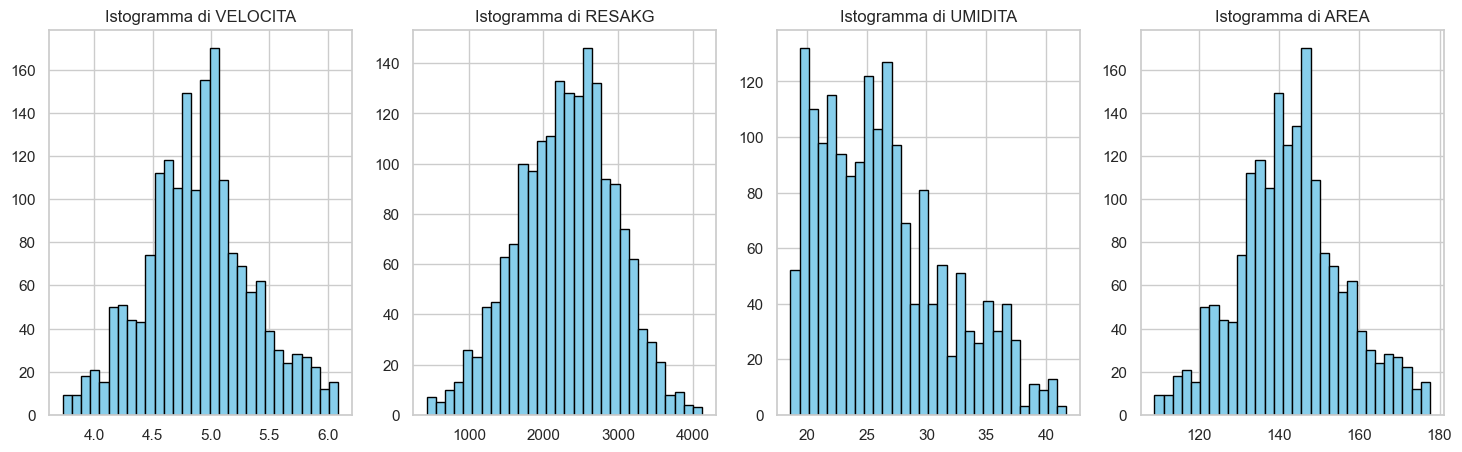

C:\Users\wolf9\AppData\Local\Temp\ipykernel_29424\1341345815.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gdf[col], ax=axes[i], shade=True)
C:\Users\wolf9\AppData\Local\Temp\ipykernel_29424\1341345815.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gdf[col], ax=axes[i], shade=True)
C:\Users\wolf9\AppData\Local\Temp\ipykernel_29424\1341345815.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gdf[col], ax=axes[i], shade=True)
C:\Users\wolf9\AppData\Local\Temp\ipykernel_29424\1341345815.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in sea

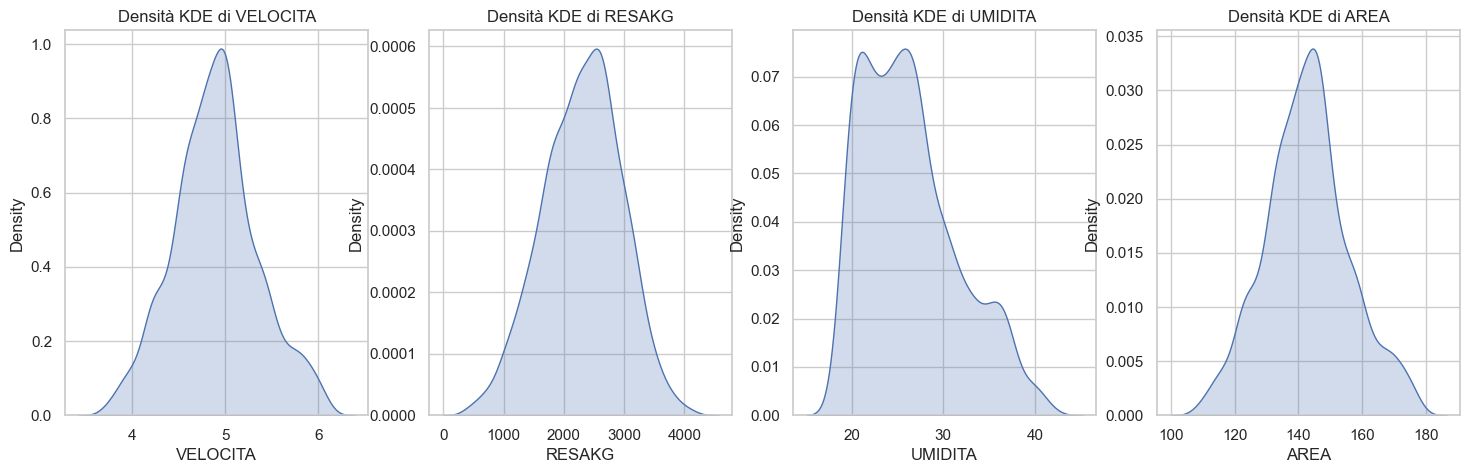

In [211]:
# Istogramma per ciascuna variabile
cols_to_check = ['VELOCITA', 'RESAKG', 'UMIDITA', 'AREA']
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i, col in enumerate(cols_to_check):
    axes[i].hist(gdf[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Istogramma di {col}')
plt.show()

# KDE plot per ciascuna variabile
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i, col in enumerate(cols_to_check):
    sns.kdeplot(gdf[col], ax=axes[i], shade=True)
    axes[i].set_title(f'Densità KDE di {col}')
plt.show()

In [212]:

# Esegui il test di Shapiro-Wilk per ciascuna variabile
for col in cols_to_check:
    # Calcola skewness e kurtosis 
    col_skew = skew(gdf[col])
    col_kurt = kurtosis(gdf[col])
    
    
    print(f"Skewness per {col}: {col_skew:.3f}")
    print(f"Kurtosis per {col}: {col_kurt:.3f}")
    
    # Esegui il test di Shapiro-Wilk
    stat, p = shapiro(gdf[col])
    print(f'Test di Shapiro-Wilk per {col}: statistic={stat:.3f}, p={p:.3f}')
    
    # Verifica la normalità
    if p > 0.05:
        print(f'I dati di {col} seguono una distribuzione normale (p > 0.05)')
    else:
        print(f'I dati di {col} non seguono una distribuzione normale (p < 0.05)')


Skewness per VELOCITA: 0.154
Kurtosis per VELOCITA: -0.039
Test di Shapiro-Wilk per VELOCITA: statistic=0.993, p=0.000
I dati di VELOCITA non seguono una distribuzione normale (p < 0.05)
Skewness per RESAKG: -0.158
Kurtosis per RESAKG: -0.244
Test di Shapiro-Wilk per RESAKG: statistic=0.997, p=0.000
I dati di RESAKG non seguono una distribuzione normale (p < 0.05)
Skewness per UMIDITA: 0.687
Kurtosis per UMIDITA: -0.269
Test di Shapiro-Wilk per UMIDITA: statistic=0.945, p=0.000
I dati di UMIDITA non seguono una distribuzione normale (p < 0.05)
Skewness per AREA: 0.154
Kurtosis per AREA: -0.039
Test di Shapiro-Wilk per AREA: statistic=0.993, p=0.000
I dati di AREA non seguono una distribuzione normale (p < 0.05)


In [213]:
scaler = StandardScaler()
gdf[['RESAKG', 'VELOCITA', 'AREA', 'UMIDITA']] = scaler.fit_transform(gdf[['RESAKG', 'VELOCITA', 'AREA', 'UMIDITA']])

print(gdf)

                  Data/Ora  Longitudin  Latitudine    RESAKG  VELOCITA  \
0     5 set 2022, 10:08:09  11,9758245  44,8474908 -0.660808 -0.211693   
1     5 set 2022, 10:08:24  11,9758157  44,8476751 -1.583126 -0.145174   
2     5 set 2022, 10:08:40  11,9758154  44,8478795 -1.352547 -0.256039   
3     5 set 2022, 10:08:55  11,9758209  44,8480593 -0.445601 -0.100828   
4     5 set 2022, 10:09:10  11,9758201  44,8482443 -1.506266 -0.211693   
...                    ...         ...         ...       ...       ...   
1811  3 set 2022, 20:13:03  11,9757431  44,8480422 -0.061302 -0.278212   
1812  3 set 2022, 20:13:19  11,9757395  44,8482399  0.246138 -0.256039   
1813  3 set 2022, 20:13:34  11,9757408  44,8484282  0.046302 -0.256039   
1814  3 set 2022, 20:13:49  11,9757414   44,848618 -0.537833  0.209593   
1815  3 set 2022, 20:14:05  11,9757344  44,8488297 -0.753040  1.207375   

          AREA   UMIDITA                         geometry  
0    -0.211694  0.125232  POINT (1333142.685 559754

Controll del sistema di riferimento delle coordinate

EPSG:3857


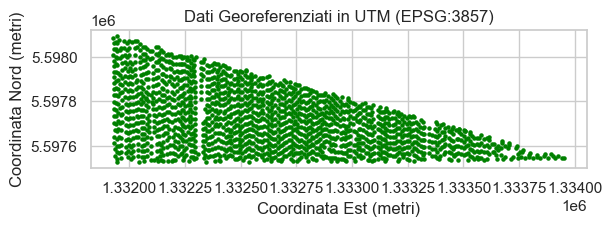

In [214]:
# Controllo del sistema di coordinate attuale
print(gdf.crs)

gdf.plot(marker='o', color='green', markersize=5)
plt.title("Dati Georeferenziati in UTM (EPSG:3857)")
plt.xlabel("Coordinata Est (metri)")
plt.ylabel("Coordinata Nord (metri)")
plt.show()

EPSG:3857
EPSG:32632


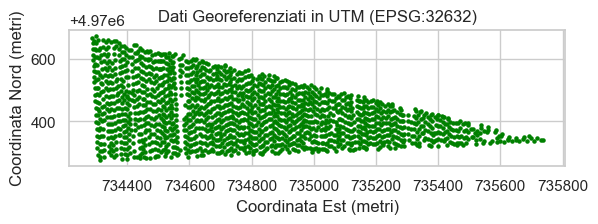

In [215]:
# Controllo del sistema di coordinate attuale
print(gdf.crs)

# Converti il CRS da EPSG:3857 a EPSG:32632
gdf = gdf.to_crs(epsg=32632)


print(gdf.crs)



gdf.plot(marker='o', color='green', markersize=5)
plt.title("Dati Georeferenziati in UTM (EPSG:32632)")
plt.xlabel("Coordinata Est (metri)")
plt.ylabel("Coordinata Nord (metri)")
plt.show()

Correlazione tra i dati quantitativi

            RESAKG  VELOCITA      AREA   UMIDITA
RESAKG    1.000000 -0.314590 -0.314591 -0.166476
VELOCITA -0.314590  1.000000  1.000000 -0.152357
AREA     -0.314591  1.000000  1.000000 -0.152357
UMIDITA  -0.166476 -0.152357 -0.152357  1.000000


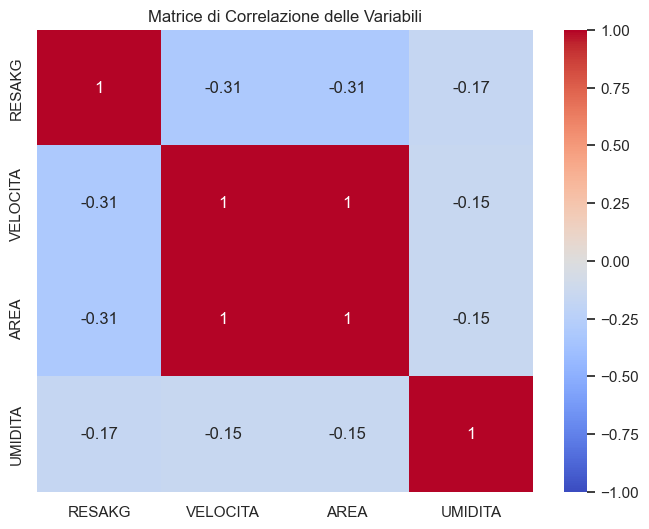

In [216]:
columns_of_interest = ['RESAKG', 'VELOCITA','AREA','UMIDITA']
correlation_matrix = gdf[columns_of_interest].corr(method='pearson')

# Mostra la matrice di correlazione
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice di Correlazione delle Variabili")
plt.show()

Interpolazione spaziale 

In [217]:
def kriging_interpolation(dataframe, variable, gridx, gridy, filename, variogram_model='exponential'):
    # Estrazione delle coordinate (x, y) dai punti geospaziali nel GeoDataFrame
    x_coords = dataframe.geometry.x
    y_coords = dataframe.geometry.y
    
    # Estrazione dei valori della variabile da interpolare
    data_values = dataframe[variable]
    
    # Controlla che non ci siano valori NaN o infiniti nei dati
    if data_values.isnull().any():
        print(f"Attenzione: la variabile {variable} contiene valori NaN. Verifica i dati.")
        return None
    
    # Creazione dell'oggetto Kriging
    OK = OrdinaryKriging(
        x_coords, y_coords, data_values, 
        variogram_model=variogram_model, verbose=False, enable_plotting=False
    )
    
    # Esecuzione dell'interpolazione sulla griglia definita
    z, ss = OK.execute('grid', gridx, gridy)
    
    # Controlla il range dei valori interpolati (per debug)
    print(f"Range dei valori interpolati per {variable}: {z.min()} a {z.max()}")
    
    # Calcolo della trasformazione affine per il raster
    transform = from_origin(gridx[0], gridy[-1], (gridx[1] - gridx[0]), (gridy[1] - gridy[0]))
    
    # Salvataggio del risultato in un file raster (GeoTIFF)
    with rasterio.open(
        filename, "w", driver="GTiff", height=z.shape[0], width=z.shape[1],
        count=1, dtype=z.dtype, crs="EPSG:4326", transform=transform
    ) as dst:
        dst.write(z, 1)
    
    return z


gridx = np.linspace(gdf.geometry.x.min(), gdf.geometry.x.max(), 100)  # Intervallo lungo l'asse x
gridy = np.linspace(gdf.geometry.y.min(), gdf.geometry.y.max(), 100)  # Intervallo lungo l'asse y

# Lista delle variabili da interpolare
variables = ['RESAKG', 'VELOCITA', 'AREA', 'UMIDITA']
interpolated_maps = {}

# Interpolazione per ogni variabile e salvataggio dei risultati
for var in variables:
    filename = f"{var}_interpolated.tif"  # Nome del file di output
    z = kriging_interpolation(gdf, var, gridx, gridy, filename)
    
    if z is not None:  
        interpolated_maps[var] = z

# Visualizzare la mappa interpolata della variabile 'RESAKG' come esempio
if 'RESAKG' in interpolated_maps:
    plt.imshow(interpolated_maps['RESAKG'], extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()), origin="lower")
    plt.colorbar(label="Resa interpolata (kg)")
    plt.scatter(gdf.geometry.x, gdf.geometry.y, c='red', s=1, label='Dati originali')
    plt.legend()
    plt.title("Interpolazione della resa agricola")
    plt.xlabel("Longitudine")
    plt.ylabel("Latitudine")
    plt.show()
else:
    print("L'interpolazione per RESAKG non è riuscita.")


KeyboardInterrupt: 

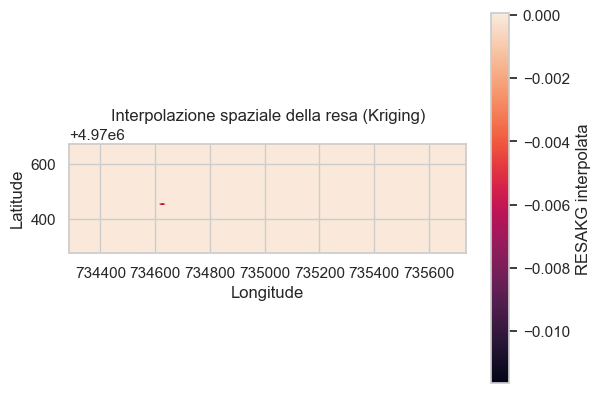

In [ ]:
plt.imshow(z, extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()), origin="lower")
plt.colorbar(label="RESAKG interpolata")
plt.title("Interpolazione spaziale della resa (Kriging)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
# Genera valori sintetici di NDVI nell'intervallo [0.2, 0.9] per ogni riga nel GeoDataFrame
ndvi_values = np.random.uniform(0.2, 0.9, len(gdf))

# Aggiungi i valori di NDVI come nuova colonna nel GeoDataFrame
gdf['NDVI'] = ndvi_values

print(gdf.head())  # Visualizza le prime righe per controllo
# Verifica le colonne del GeoDataFrame
print(gdf.columns)


               Data/Ora  Longitudin  Latitudine    RESAKG  VELOCITA      AREA  \
0  5 set 2022, 10:08:09  11,9758245  44,8474908 -0.660808 -0.211693 -0.211694   
1  5 set 2022, 10:08:24  11,9758157  44,8476751 -1.583126 -0.145174 -0.145175   
2  5 set 2022, 10:08:40  11,9758154  44,8478795 -1.352547 -0.256039 -0.256014   
3  5 set 2022, 10:08:55  11,9758209  44,8480593 -0.445601 -0.100828 -0.100854   
4  5 set 2022, 10:09:10  11,9758201  44,8482443 -1.506266 -0.211693 -0.211694   

    UMIDITA                        geometry      NDVI  
0  0.125232  POINT (735162.553 4970317.483)  0.588800  
1  0.125232  POINT (735161.107 4970337.931)  0.555329  
2  0.125232  POINT (735160.251 4970360.636)  0.736484  
3  1.289785  POINT (735159.953 4970380.625)  0.224128  
4  1.289785  POINT (735159.136 4970401.173)  0.728972  
Index(['Data/Ora', 'Longitudin', 'Latitudine', 'RESAKG', 'VELOCITA', 'AREA',
       'UMIDITA', 'geometry', 'NDVI'],
      dtype='object')


In [ ]:
# Calcolare la correlazione tra la colonna RESAKG e la colonna NDVI
correlazione = gdf[['RESAKG','NDVI']].corr(method='pearson')

print("Correlazione tra RESAKG e NDVI:")
print(correlazione)

Correlazione tra RESAKG e NDVI:
          RESAKG      NDVI
RESAKG  1.000000  0.004029
NDVI    0.004029  1.000000


In [ ]:
# ee.Authenticate()
# ee.Initialize()
# features = []
# for _, row in gdf.iterrows():
#     geom = ee.Geometry.Point([row.geometry.x, row.geometry.y])
#     feature = ee.Feature(geom)
#     features.append(feature)

# points = ee.FeatureCollection(features)

# # Filtra le immagini per l’anno scorso e la regione di interesse
# collection = ee.ImageCollection("COPERNICUS/S2") \
#     .filterDate('2023-01-01', '2023-12-31') \
#     .filterBounds(points)

# # Funzione NDVI
# def add_ndvi(image):
#     ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
#     return image.addBands(ndvi)

# ndvi_collection = collection.map(add_ndvi)

# # Media NDVI annuale
# mean_ndvi = ndvi_collection.select('NDVI').mean()
# # Riduzione per ottenere NDVI per ciascun punto
# ndvi_values = mean_ndvi.reduceRegions(
#     collection=points,
#     reducer=ee.Reducer.mean(),
#     scale=10  # Risoluzione in metri
# )

# # Stampa i risultati
# result = ndvi_values.getInfo()
# print(result)

# task = ee.batch.Export.table.toDrive(
#     collection=ndvi_values,
#     description='NDVI_Export',
#     fileFormat='CSV'
# )
# task.start()
